Подгрузка нужных библиотек и датасетов

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set() # устанавливаем seaborn как по-умолчанию для отрисовки графиков

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Посмотрим на зависимость Transported от некоторых столбцов:
1) Cryosleep - Большая часть True спаслась
2) VIP - Примерно половина False спаслась, True меньше 40%
3) HomePlanet и Destination для всех точек отличается, важно это учесть

<Axes: xlabel='Destination', ylabel='Transported'>

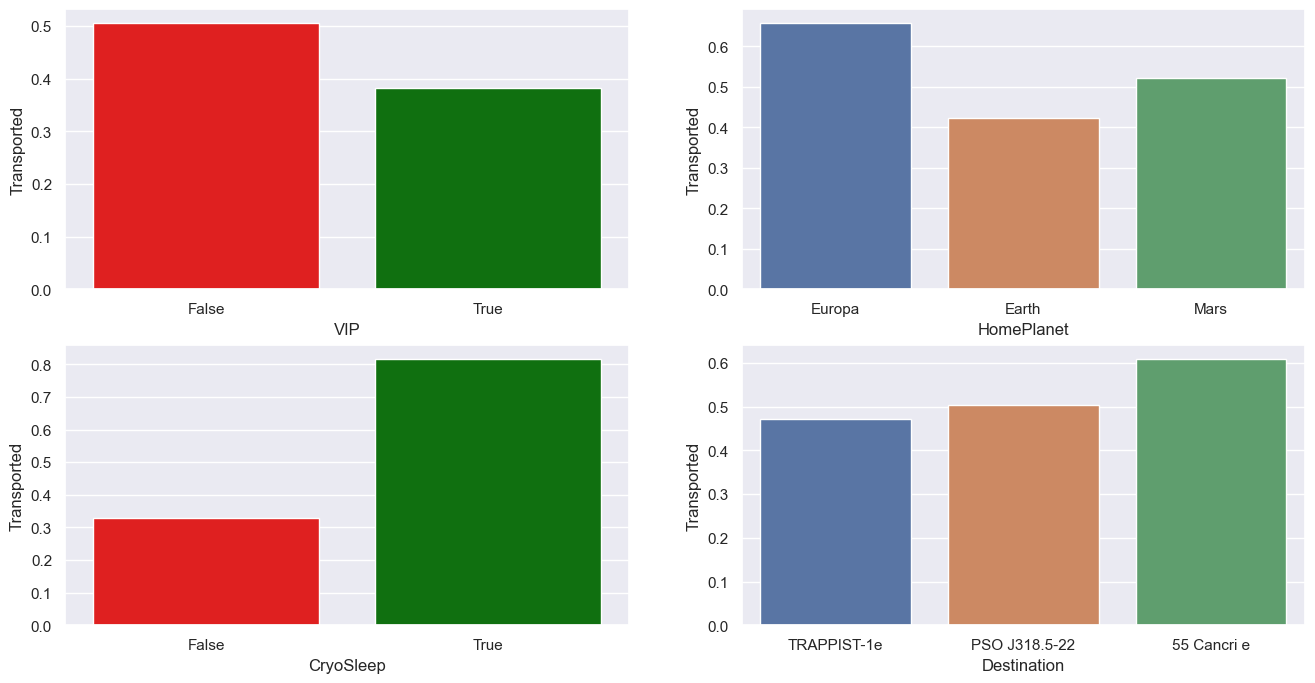

In [121]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.barplot(x='VIP', y='Transported',hue='VIP',legend=False, data=train, errorbar=None, ax=ax1, palette={True: 'green', False: 'red'}) # hue для требований seaborn, и отключаем легенду для исключения дублирования
sns.barplot(x='HomePlanet', y='Transported',hue='HomePlanet',legend=False, data=train, errorbar=None, ax=ax2)
sns.barplot(x='CryoSleep', y='Transported',hue='CryoSleep',legend=False, data=train, errorbar=None, ax=ax3, palette={True: 'green', False: 'red'})
sns.barplot(x='Destination', y='Transported',hue='Destination',legend=False, data=train, errorbar=None, ax=ax4)

Посмотрим на зависимость от трат на доп услуги:
Замечаем, что чем больше расходы, тем меньше становится жертв по отношению к спасённым.
Исключением является категория людей, не приобритавших доп услуги - в этой категории спасённых намного больше.


<Axes: xlabel='ExpenseCategory', ylabel='Count'>

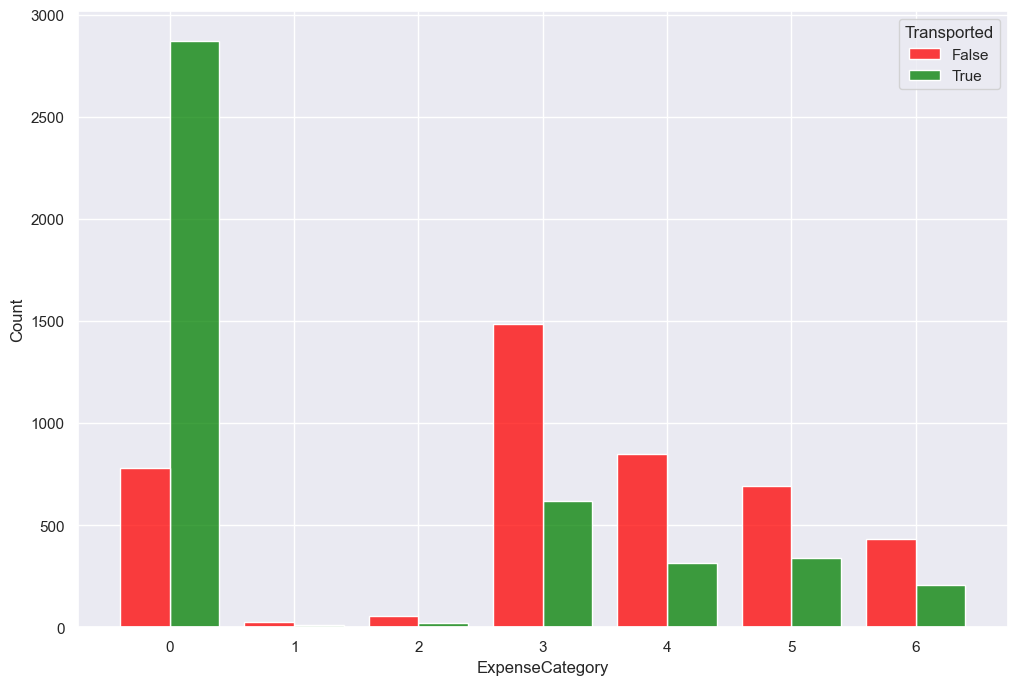

In [122]:
# Создаем столбец с общей суммой расходов
train['TotalExpense'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Создаем категории расходов
bins = [-1, 0, 100, 500, 1000, 2000, 5000, float('inf')]
labels = [0, 1, 2, 3, 4, 5, 6]
train['ExpenseCategory'] = pd.cut(train['TotalExpense'], bins=bins, labels=labels)

plt.figure(figsize=(12, 8))

sns.histplot(
    data=train,
    x='ExpenseCategory',
    hue='Transported',
    multiple='dodge',  # Столбцы рядом друг с другом
    shrink=0.8,        # уменьшаем ширину столбцов для лучшего разделения
    palette={True: 'green', False: 'red'}
)

Теперь посмотрим на корреляцию расходов на отдельные доп услуги и спасения. Может VR находится рядом с спасательной капсулой?
Предварительно перобразуем столбец из True и False в 1 и 0.

<Axes: >

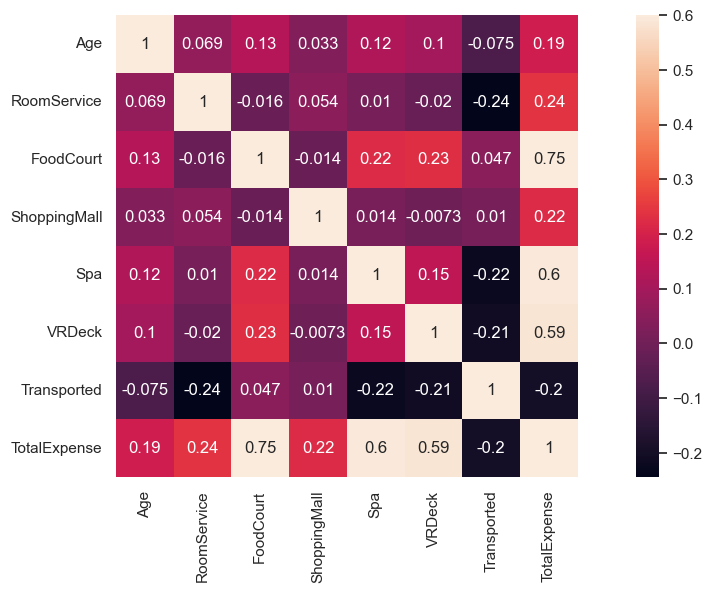

In [123]:
# Преобразование True/False в 1/0
train['Transported'] = train['Transported'].astype(int)

# Выберем только числовые колонки для корреляционного анализа
numeric_columns = train.select_dtypes(include=[np.number]).columns

# Вычислим корреляционную матрицу только для числовых данных
corr_matrix = train[numeric_columns].corr()

plt.figure(figsize=(15,6))
sns.heatmap(corr_matrix, vmax=0.6, square=True, annot=True)

Замечаем, что RoomService,Spa,VRDeck отрицательно влияют на выживаемость. Добавим столбцы is_Spa, is_VRDeck, is_RoomService.

In [124]:
# Создаем бинарные признаки для расходов
train['is_RoomService'] = (train['RoomService'] > 0).astype(int)
train['is_Spa'] = (train['Spa'] > 0).astype(int)
train['is_VRDeck'] = (train['VRDeck'] > 0).astype(int)


Приступим к анализу влияния возраста

<Axes: xlabel='Transported', ylabel='Age'>

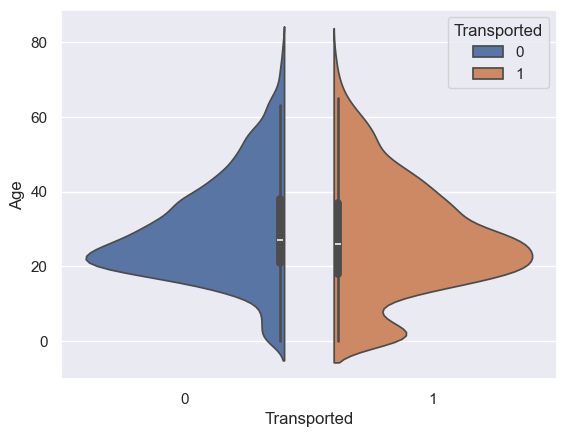

In [125]:
sns.violinplot(x="Transported", y="Age", hue="Transported", data=train, split=True)

Замечаем, что целевые группы среди спасённых дети и люди молодого-среднего возраста. Поделим на группы по возрасту.

<Axes: xlabel='AgeCategory', ylabel='Count'>

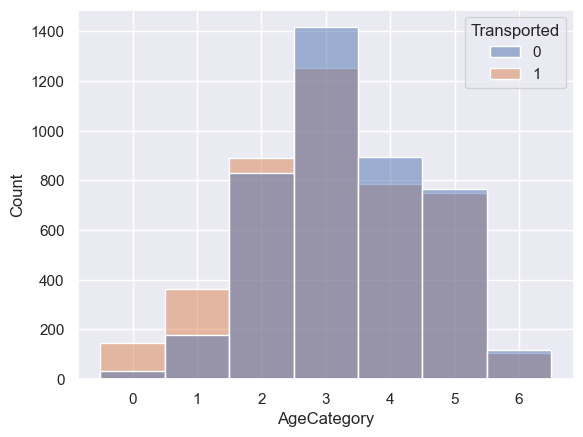

In [127]:
bins = [-1, 0, 10, 20, 30,40,60,80,100]
labels = [0, 1, 2, 3, 4, 5, 6,7]
train['AgeCategory'] = pd.cut(train['Age'], bins=bins, labels=labels)
sns.histplot(
    data=train,
    x='AgeCategory',
    hue='Transported',
)

Проанализируем зависимость от расположения каюты. Значала разделим на людей по типу каюты: P for Port/S for Starboard

In [129]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpense,ExpenseCategory,is_RoomService,is_Spa,is_VRDeck,AgeCategory
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0,0,0,0,0,4
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0,3,1,1,1,3
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,10383.0,6,1,1,1,5
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0,6,0,1,1,4
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0,4,1,1,1,2
